In [1]:
# -----------------------------------------------------------Assignment Report and Code ----------------------------------------------------
# Part 1.1: Describe the dataset

#     The product category I selected is the Video Games category, with two variations of the datasets included: 5-Core reviews dataset and all reviews dataset. The 5-Core dataset contains only reviews from users and products with at least five reviews, while all reviews dataset contain every review entry, subsequently making it much more diverse. There are a total of 1324753 reviews; however, the 5-Core dataset only contains 231780 reviews. There is also a file for metadata dataset; however, that is a completely different set of information rather than a variation. Metadata contains information regarding each product. Only the 5-Core reviews dataset will be used in this analysis. This is because video games is a highly competitive market with multiple online stores available. Amazon does not have its own social platform for gaming (unlike Steam, Origin or Epic Store), making it less popular in general. However, a lot of people buy video games from Amazon when sales are happening. These customers are however unlikely to leave a review on Amazon. Nevertheless, if a user provides multiple reviews on Amazon, it is more likely that they use Amazon to buy video games in general. Therefore, I assume that their reviews should be more reliable than one-off customers. Likewise, as for video games, a lot of games are based on different platforms and people usually buy the games on their respective platforms. This means that there are much fewer copies being sold on Amazon. Products with less than five reviews are likely to have a very small share in the market and do not reflect the trend within the category.

#     The reviews and metadata can be linked together using the Amazon Standard Identification Number (ASIN) unique to each product. Both variations of the reviews dataset contains reviewerID and asin as the identifier, with other attributes being reviewerName, helpful, reviewText, overall, summary, unixReviewTime, and reviewTime. The metadata uses asin as the identifier and contains description, price, imURL, related, salesRank, categories, title, and brand. The attributes I will be using from the product data are the asin, description, price, related, salesRank, title and brand, while every attribute of the review data will be used in this analysis. Only video games product will be included in the analysis, meaning that electronics and gaming equipment will be filtered out for this report.

In [2]:
### Part 1.2: Describe the steps you used for data preparation and preprocessing
# I use the code provided at the source of the dataset to extract DataFrames from the downloaded files, then save each of them into Apache Parquet files using the df.to_parquet function in pandas. The detailed implementation of this can be found in the code written later in this notebook. 

# As for normalisation, the category data is split into multiple columns with a boolean representing each value instead of being contained in a single object. Similarly, the salesRank data will also be unwrapped from the dictionary object into a number. The brand and title of each item will also be removed as most of them do not have a value and will not contribute to the analysis. Since this analysis is focused on video games category, only the video games sales rank will be retained. Helpful column in reviews data will also be split into upvotes and downvotes. Moreover, related items will be removed from the metadata as we are not analysing the relationship between each item. UnixReviewTime will also be excluded as users are from different parts of the world; therefore they are from different timezones and it wll be hard to determine the relationship between time of the day and the reviews.


# For the metadata, items without a price is excluded as they tend to be some uncommon product people sell on the store. To clarify, standard products on Amazon should have their price listed, and the ones without are those sold by users. As a result, they are too inconsistent and unreliable for the analysis. Moreover, the metadata for the products not mentioned by the reviews in the 5-Core dataframe will also be filtered out of the analysis. ImageUrl will also be removed as the column is not required for the analysis. Reviewer Names will be excluded from the analysis as reviewerID will be used to identify each reviewer instead. Console games will be excluded as the market's growth and evolution is completely different from that of PC games.

In [3]:
### Part 1.3: Hypothesis
# Over the course of 1996 - 2014, the video games industry has greatly evolved and there has been a clear shift from physical copies of the games into digital ones; therefore, the hypothesis for this analysis is that the popularity and sample size for digital product reviews should increase over time. Additionally, sales number should also increase greatly during seasonal sales; this should be reflected in the number of reviews over specific periods.

In [ ]:
### NOTES: SOME PARTS MAY HAVE TO BE UNCOMMENTED FOR THE CODE TO WORK INITIALLY, THESE PARTS WILL BE MARKED WITH (*)

In [120]:
# Import libraries and define parse functions for the dataset
import pandas as pd
import gzip
import sklearn
import pandas_bokeh

pandas_bokeh.output_notebook()

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0 
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient ='index')

Loading BokehJS ...

In [6]:
# ************************ generate DataFrame from 5-core reviews and save to parquet
# fiveCoreDF = getDF('reviews_Video_Games_5.json.gz')
# fiveCoreDF.to_parquet('fiveCore.parquet.gzip', compression='gzip')


In [7]:
# ************************** generate DataFrame from products metadata and save to parquet
# meta = getDF('meta_Video_Games.json.gz')
# meta.to_parquet('metadata.parquet.gzip', compression='gzip')

In [8]:
# #generate DataFrame from all category reviews and save to parquet
# allDF = getDF('reviews_Video_Games.json.gz')
# allDF.to_parquet('all.parquet.gzip', compression='gzip')
# This dataset is excluded from the analysis for the reasons stated at the beginning

In [9]:
#Read metadata from parquet and store it in a variable
OG_metadata = pd.read_parquet('metadata.parquet.gzip')

In [10]:
# Read 5-Core reviews data from parquet and store it in a variable
OG_reviews= pd.read_parquet('fiveCore.parquet.gzip')

In [11]:
#Data Cleaning: Remove items without a price data from the metadata
OG_metadata = OG_metadata[OG_metadata.price.notnull()]

In [12]:
# Check asin appearing in 5-Core reviews DataFrame
reviewedGames = OG_reviews.groupby("asin").groups.keys()

# Remove items not appearing in the reviews from the metadata
metadata = OG_metadata[OG_metadata.asin.isin(reviewedGames)].reset_index()

In [13]:
#make ASIN index for metadata, remove 'index' column

metadata.set_index('asin', inplace = True)
metadata.drop(axis = 1, labels = 'index', inplace = True)

In [14]:
#remove imageurl from metadatareviewTime')
metadata.drop(axis = 1, labels = 'imUrl', inplace = True)
#remove title from metadata
metadata.drop(axis = 1, labels = 'title', inplace = True)
#remove brand from metadata
metadata.drop(axis = 1, labels = 'brand' , inplace = True)
#remove related items from metadata
metadata.drop(axis = 1, labels = 'related', inplace = True)

In [15]:
# metadata.replace(metadata["categories"], metadata["categories"])
def unwrapCategory(data):
    return data[0]

metadata["categories"] = metadata["categories"].apply(unwrapCategory)

In [16]:
#Unwrap metadata saleRank, retrieving only Video Games rank
temp = metadata["salesRank"].apply(pd.Series)["Video Games"]
#add unwrapped values to the original dataframe
metadata["rank"] = temp
####### Some rows do not contain Video Games Rank, it should be safe to assume that they are video games related but not actually video games. Therefore, they will be removed from the analysis

metadata = metadata.dropna(axis = 'index', how = 'any', subset = ['rank'])



In [17]:
#change metadata.rank to integer

metadata["rank"] = metadata["rank"].apply(lambda x: int(x))

#remove salesRank from the dataframe

metadata.drop(axis = 1, labels = 'salesRank', inplace = True)


In [18]:
#Delete ReviewerName from reviews
OG_reviews.drop(axis = 1, labels = 'reviewerName', inplace = True)

In [19]:
#Unwrap Helpful into Upvotes and Downvotes
helpfulDF = pd.DataFrame(OG_reviews["helpful"].to_list(), columns = ['upvotes', 'downvotes'])

#join reviews with unwrapped helpful stats, dropping helpful column
reviews = OG_reviews.join(helpfulDF)
reviews.drop(axis = 1, labels = 'helpful', inplace = True)




In [20]:
def getCategories(data):
    newItem = dict()
    for cat in data:
        if cat == 'PC':
            newItem['PC'] = True
        if cat == 'Mac':
            newItem['Mac'] = True
        if cat == 'Software':
            newItem['Software'] = True
        if cat == 'Digital Game':
            newItem['Digital Game'] = True
        if cat == 'PC Game Downloads':
            newItem['PC Game Downloads'] = True
        if cat == 'Linux Games':
            newItem['Linux Games'] = True
        if cat == 'Mac Game Downloads':
            newItem['Mac Game Downloads'] = True
        if cat == 'MMO & Free-to-Play Games':
            newItem['MMO & Free-to-Play Games'] = True
    return newItem

#check unique types in metadata
test = metadata["categories"].explode()
categoriesDF = pd.DataFrame(columns=["asin", "PC", "Games", "Mac", "Software", "Digital Game", "PC Game Downloads", "Digital Games & DLC", "Linux Games", "Mac Game Downloads", "MMO & Free-to-Play Games"])



In [21]:
#unwrap selected categories, reset the index, then turn into a dataframe
test = test.groupby(["asin"]).apply(getCategories).reset_index()
test = pd.DataFrame(test)

In [22]:
#Transform categories data into a pivot table then unwrap
test = pd.pivot_table(test, values = ["categories"], index = ['asin'], columns = ['level_1'], aggfunc = lambda x: x)
test = test['categories']

In [23]:
#merge the categories data back to original metadata. 
metadata = metadata.join(test)
#delete categories column
metadata.drop(axis = 1, labels = 'categories', inplace = True)

In [24]:
#remove non-video games items by checking if they do not belong in any of the categories (all categories value = NaN)

metadata.dropna(axis = 0, subset = ["Linux Games", "MMO & Free-to-Play Games", "Mac", "Mac Game Downloads", "PC", "PC Game Downloads", "Software"], how = "all", inplace = True)

In [25]:
#remove reviews for items not in processed metadata
#remove extra index
reviews = reviews[reviews['asin'].isin(metadata.index)].reset_index()
reviews.drop(axis = 1 , labels = 'index', inplace = True)

In [26]:
#convert reviewTime to datetime, dropping unixReviewTime
reviews['reviewTime'] = pd.to_datetime(reviews['reviewTime'], format = '%m %d, %Y')
reviews.drop( axis = 1, labels = "unixReviewTime", inplace = True)

In [27]:
### Part 2: Advanced Analysis
### Explanation: As we are only focusing on PC Game data for this part, the 'large events' in this analysis are the launches of arguably two largest digital video games markets, Steam and Origin. Steam was launched on September 12, 2003 by Valve Corporation and was initially for in-house games. However, it later expanded to include games from other publishers and eventually became the largest video games platform. Origin was launched on June 3, 2011 by EA Corporation. These two platforms greatly influenced the shift from physical video games products (CDs, DVDs) into digital copies. Therefore, this analysis will mostly be divided into three periods: 1996 - September 11, 2003, September 12, 2003 - June 2, 2011, and June 3, 2011 - latest data. These are determined by the launch of platforms mentioned above.


#2.1 > The large events defined at the beginning of this part greatly affect the number of reviews on digital products. The percentage increase from 0.16% to 0.45% for the second period, and skyrocketed up to 22.14% on the last period where more products transitioned into digital copies. 


#2.2 > Holidays greatly affect the sales amount for products in the Video Games category. As seen in multiple plots below, there is an increase after October (Halloween Sales) and December (Christmas and New Year's Sales). The number of reviews also increases in March as it is where Amazon usually holds a Spring Sale event. There is a surge in reviews number on December 28th, this is likely to be the consequence of Christmas and holiday season as people finally receive their gifts and play. One thing to note is; however, that users who only use Amazon to buy video games during the promotion seldom leave a review as they tend to use other platforms in general.

#2.3 > Note that Amazon is not a popular platform for this purpose so product popularity might not be as accurate compared to using data from Steam or Origin. The use of internet has also greatly increased between the second and third period. The second period is roughly almost three times longer than the third period; however, there are more reviews from the third period. 
# Unlike other products, it is impossible to determine the general trend based solely on the time of the year (not counting the holidays and speical events). However, most video games tend to become outdated after a few months of release. After the product becomes outdated, new reviews and sales revenue usually come from customers who buy them during the seasonal sale. 

#2.4 > Multiple Plots showing number of reviews by day, week, month and year are available below. This is done through the use of resampling.

In [28]:
# filter reviews by date of each event ( before 2003-09-12 and before 2011-06-03)
reviews_first = reviews.loc[(reviews['reviewTime'] < '2003-09-12')]
reviews_second = reviews.loc[(('2003-09-12' < reviews['reviewTime']) & (reviews['reviewTime'] < '2011-06-03')) ]
reviews_third = reviews.loc[('2011-06-03' <= reviews['reviewTime'])]

In [29]:
reviews.count()
reviews.groupby(['asin']).size()
reviews.groupby(['reviewerID']).size()
#there are a total of 1778 games being reviewed in total, with 33276 reviews and 9493 different reviewers

reviewerID
A0266076X6KPZ6CCHGVS     2
A05026511FQMVPVJH3KP8    2
A0815906MFVDTIFHGRQR     2
A08324222HTYZDE4L3F8Z    2
A100F925TP0C0X           3
                        ..
AZXWP83KBEA7N            4
AZY1N2YRSROMQ            1
AZYIAWJR9972L            4
AZYJE40XW6MFG            1
AZZKH219IDQGY            5
Length: 9493, dtype: int64

In [30]:
reviews_first.count()
#there are a total of 3278 reviews in this period on 376 different items. The reviews are from 1205 different reviewers.
# reviews_first.groupby(['asin']).size().count()
# reviews_first.groupby(['reviewerID']).size().count()

reviewPerUser = 3278 / 1205
reviewPerGame = 3278 / 376 
print ("Review per User:", reviewPerUser)
print ("Review per Game:", reviewPerGame)

Review per User: 2.720331950207469
Review per Game: 8.71808510638298


In [97]:
firstPeriod = reviews_first.groupby('reviewTime').size().count()
#there are a total of 1189 different days with at least a review in this period


In [31]:
reviews_second.count()
# reviews_second.groupby(['asin']).size().count()
# reviews_second.groupby(['reviewerID']).size().count()
#there are 14339 reviews in this period on 1289 different items, 4385 different reviewers.

reviewPerUser = 14339 / 4382
reviewPerGame = 14339 / 1289
print ("Review per User:", reviewPerUser)
print ("Review per Game:", reviewPerGame)

Review per User: 3.2722501141031493
Review per Game: 11.12412723041117


In [100]:
secondPeriod = reviews_second.groupby('reviewTime').size().count()
#there are a total of 2748 different days with at least a review in this period

In [85]:
reviews_third.count()
# reviews_third.groupby(['asin']).size().count()
# reviews_third.groupby(['reviewerID']).size().count()
# there are 15207 reviews in this period on 1494 different items from 5980 users.
reviews_third.groupby('reviewTime').count()

reviewPerUser = 15207 / 5980
reviewPerGame = 15207 / 1494
print ("Review per User:", reviewPerUser)
print ("Review per Game:", reviewPerGame)

Review per User: 2.5429765886287625
Review per Game: 10.17871485943775


In [99]:
thirdPeriod = reviews_third.groupby('reviewTime').size().count()
#there are a total of 1144 different days with at least a review in this period

In [101]:
print ("Days with a review for Each period")
print ("First period:", firstPeriod)
print ("Second period:", secondPeriod)
print ("Third period:", thirdPeriod)

Days with a review for Each period
First period: 1189
Second period: 2748
Third period: 1144


In [33]:
#checking the number of items in PC Game Downloads Category and percentage of reviews on those items compared to overall reviews

digitalGames = metadata.loc[((metadata["PC Game Downloads"] == True) | (metadata["Mac Game Downloads"] == True))]

In [34]:
#generate reviews df for digital products on each period
digitalReviews_first = reviews_first.loc[reviews_first['asin'].isin(digitalGames.index)]
digitalReviews_second = reviews_second.loc[reviews_second['asin'].isin(digitalGames.index)]
digitalReviews_third = reviews_third.loc[reviews_third['asin'].isin(digitalGames.index)]

In [35]:
print ("First period reviews on digital products:", digitalReviews_first['reviewerID'].count())
print ("Second period reviews on digital products:", digitalReviews_second['reviewerID'].count())
print ("Third period reviews on digital products:", digitalReviews_third['reviewerID'].count())

First period reviews on digital products: 6
Second period reviews on digital products: 65
Third period reviews on digital products: 3367


In [36]:
#Compare digital product reviews to total reviews
print ("First period digital product review percentage:", (digitalReviews_first['reviewerID'].count()/reviews_first['reviewerID'].count())*100)
print ("Second period digital product review percentage:", (digitalReviews_second['reviewerID'].count()/reviews_second['reviewerID'].count())*100)
print ("Third period digital product review percentage:", (digitalReviews_third['reviewerID'].count()/reviews_third['reviewerID'].count())*100)

First period digital product review percentage: 0.1609442060085837
Second period digital product review percentage: 0.45330915684496825
Third period digital product review percentage: 22.14111922141119


In [37]:
#plot reviews by date in total
reviewsDate = reviews.groupby('reviewTime').size()

In [46]:
#for time-series analysis, change reviewTime into the datetimeindex
reviews['reviewTime'] = pd.to_datetime(reviews['reviewTime'], infer_datetime_format = True)
reviewsByTime = reviews.set_index('reviewTime')

<AxesSubplot:xlabel='reviewTime'>

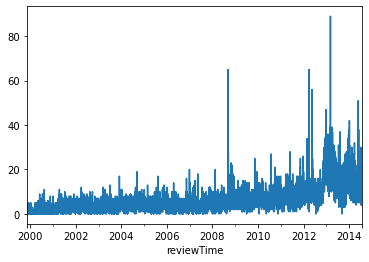

In [47]:
reviewsByDate = reviewsByTime[['reviewerID', 'asin']].resample('D').size()
reviewsByDate.plot(kind = 'line')

<AxesSubplot:xlabel='reviewTime'>

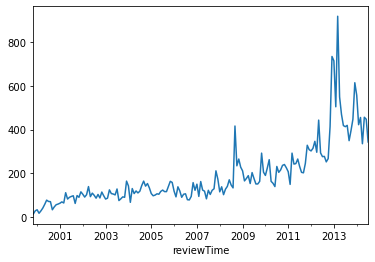

In [48]:
reviewsByMonth = reviewsByTime[['reviewerID', 'asin']].resample('M').size()
reviewsByMonth.plot(kind = 'line')

In [128]:
#check monthly trend for every year combined

monthlyReviews = reviewsByTime.groupby([reviewsByTime.index.month], as_index = True).size()
monthlyReviews.plot_bokeh().line()


GlyphRenderer(id='1401', ...)

In [84]:
print ("Average Reviews per Month:", monthlyReviews.mean())
months = [0, "Jan", "Feb", "Mar", "Apr", "May", "June", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

#total reviews each month
for i in range (1, 13):
    print ("Total reviews for", months[i], monthlyReviews[i])

Average Reviews per Month: 2773.0
Total reviews for Jan 3095
Total reviews for Feb 2529
Total reviews for Mar 3399
Total reviews for Apr 2754
Total reviews for May 2828
Total reviews for June 2726
Total reviews for Jul 2677
Total reviews for Aug 2158
Total reviews for Sep 2346
Total reviews for Oct 2367
Total reviews for Nov 3034
Total reviews for Dec 3363


In [130]:
#Check weekly trend for every year combined
weeklyReviews = reviewsByTime.groupby([reviewsByTime.index.month, reviewsByTime.index.isocalendar().week], as_index = True).size()
weeklyReviews.plot_bokeh().line()


GlyphRenderer(id='1576', ...)

In [127]:
#Check daily trend for every year combined
dailyReviews = reviewsByTime.groupby([reviewsByTime.index.month, reviewsByTime.index.day], as_index = True).size()
dailyReviews.plot_bokeh().line()

GlyphRenderer(id='1241', ...)

reviewTime  reviewTime
1           1             152
            2             142
            3             118
            4             117
            5             123
                         ... 
12          27            138
            28            172
            29            114
            30            110
            31            123
Length: 366, dtype: int64

In [131]:
reviewsByYear = reviewsByTime[['reviewerID', 'asin']].resample('Y').size()
reviewsByYear.plot_bokeh().line()

GlyphRenderer(id='1860', ...)

In [ ]:
### Part 3: Evaluation
#3.1: What are the findings of your data analytics?
This analysis shows that even though Amazon is known as one of the largest online markets, for video games category, the data size reduces greatly after the pre-processing. 


#3.2: What actions for improving the products do you suggest based on your findings?
# One obvious result is that there is a huge increase in the proportion for digital version of the PC/MAC version of the video games. If a publisher wants to sell a PC game on Amazon, they will have a better chance with the digital copies than physical ones. Also putting their products on sale on other platforms should yield better results.

#3.3: How could you refine your data analytics?
# As mentioned at the beginning, Amazon is not the biggest platform for Video Games on PC/MAC. Retrieving the metadata, sales, and reviews from Steam would be the better option. Steam also includes an api and tracks users for each game regularly. Amazon is good for the analysis of many products category; however, as this analysis finds,video games is an exception. 


#3.4: Are there any implications for consumers/users of the products based on the findings you obtained or the improvements you plan to make?
# More textual analysis may be used to analyse why people obtain certain products (For example, some reviews may state that they got it as a gift, or some 
# ). Having the information regarding the promotions may also be useful as reviews from users who buy the product at full price may differ from those buying them at a discounted price. 


## The URL to the web page : https://huskyzpinto.github.io/amazonDataSite/ 